In [1]:
# libraries
%load_ext autoreload
%autoreload 2

import numpy as np
import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from PDM2PCM import *
from PCM2PDM import *
from Serialize import *
from PlotSuite import *

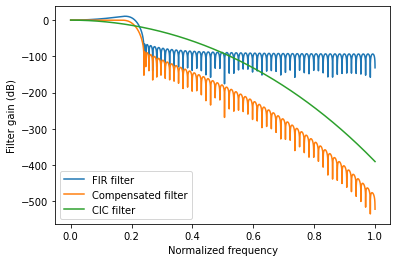

In [40]:
import sys
from scipy import signal
import numpy as np

def get_taps(N, R, M, ntaps=128, cutoff=0.2):
    """
    Find the coefficients of the half-band FIR filter that compensate the CIC filter from 0 to cutoff
    N : number of CIC stages
    R : decimation rate
    M : differential delay in the comb section stages of the filter
    """
    f = np.arange(2048) / 2047.
    cic_response = lambda f : abs( M/R * (np.sin((f*R)/2)) / (np.sin((f*M)/2.)) )**N if f !=0 else 1

    H = np.fromiter(map(cic_response, f*np.pi), dtype=np.float64)

    # Define frequency reponse of ideal compensation filter
    H = np.fromiter(map(cic_response, f*np.pi / R), dtype=np.float64)
    Hc = 1/H * (f < cutoff)

    beta = 8
    taps = signal.firwin2(ntaps, f, Hc, nfreqs = 1025, window=('kaiser', beta))
    taps /= np.sum(taps)
    return taps, cic_response

N = float(100) # number of CIC stages
R = float(16) # decimation rate
M = float(1) # differential delay

taps, cic_response = get_taps(N, R, M)

# print(', '.join('%e' % f for f in taps))

import matplotlib.pyplot as plt
w, h = signal.freqz(taps, worN=16384)
hh = np.fromiter(map(cic_response, w / R), dtype=np.float64)
hh[0] = 1
plt.plot(w / np.pi, 20 * np.log10(abs(h)), label='FIR filter')
plt.plot(w / np.pi, 20 * np.log10(abs(h * hh)), label='Compensated filter')
plt.plot(w / np.pi, 20 * np.log10(abs(hh)), label='CIC filter')
plt.xlabel('Normalized frequency')
plt.ylabel('Filter gain (dB)')
plt.legend()
# plt.ylim(-120, 20)
plt.show()

In [47]:
Hc

array(<map object at 0x000002AB2DB73730>, dtype=object)

C:\Users\levyg\AppData\Local\Temp/ipykernel_25548/824677349.py:9: RuntimeWarning: invalid value encountered in double_scalars
  Hfunc = lambda w : abs( (sin((w*M)/2)) / (sin((w*D)/2.)) )**N
C:\Users\levyg\AppData\Local\Temp/ipykernel_25548/824677349.py:10: RuntimeWarning: invalid value encountered in double_scalars
  HfuncC = lambda w : abs( (sin((w*D)/2.)) / (sin((w*M)/2.)) )**N


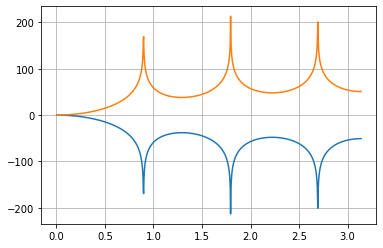

In [51]:
import numpy as np 
from numpy import sin, abs, pi, log10
import pylab

D = 1
M = 7
N = 3

Hfunc = lambda w : abs( (sin((w*M)/2)) / (sin((w*D)/2.)) )**N
HfuncC = lambda w : abs( (sin((w*D)/2.)) / (sin((w*M)/2.)) )**N

w = np.arange(1024) * pi/1024

G = (M*D)**N
H = np.fromiter(map(Hfunc, w), dtype=np.float64)
Hc = np.fromiter(map(HfuncC, w), dtype=np.float64)
# only use the inverse (compensation) roughly to the first null.
# Hc[int(1024*pi/M/2):] = 1e-8
pylab.plot(w, 20*log10(H/G))
pylab.plot(w, 20*log10(Hc*G))
pylab.grid('on')


c:\Users\levyg\Documents\MEGA\Repositories\mems2sd_esp32\python\PDMSignalProcessing\CIC.py:91: RuntimeWarning: divide by zero encountered in log10
  y = 20 * np.log10(abs(h))


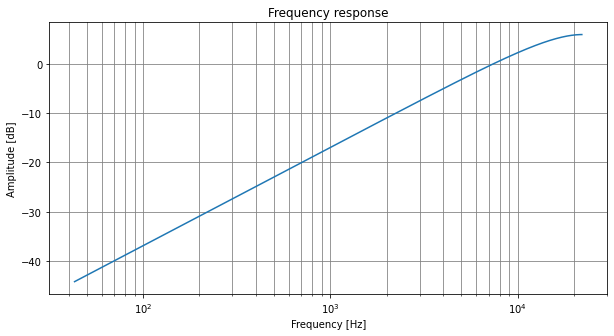

In [3]:
cic = CIC(stages=1, decimation_factor=16, differential_delay=1)
cic.freqz()

In [52]:
def swap_bytes_of_word(x):
    x = ((x & 0x000000FF) << 24) | ((x & 0xFF000000) >> 24) | ((x & 0x0000FF00) << 8) | ((x & 0x00FF0000) >> 8)
    return x

fname = "working_sine_wave_cross_testing_pdm_2_32bitsample_2000000hz"
wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/python/PDMSignalProcessing/data/"
fs_pdm = 2000000
os = 64

# np.set_printoptions(threshold=sys.maxsize, formatter={'int':hex})

data_pdm = np.fromfile(wd+fname, dtype=np.uint32)
swapped_bytes = swap_bytes_of_word(data_pdm)
byte_stream = swapped_bytes.view(dtype=np.uint8).ravel()
pdm_stream = np.unpackbits(byte_stream, axis=0).astype(np.int32)

In [8]:
fname = "sine_wave_cross_testing_pcm_44100khz"
wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/python/PDMSignalProcessing/data/"
fs_pcm = 44100
data_pcm, _ = sf.read( 
                        wd+fname, 
                        channels=1, 
                        samplerate=int(fs_pcm), 
                        format='RAW', 
                        endian='BIG', 
                        subtype='PCM_16', 
                        dtype=np.int16
                    )
data_pcm = data_pcm[int(2e5):int(2e5+2**16)]

In [ ]:
full_plot(data_pcm, fs_pcm, short=False, title='44100kHz PCM data - 10kHz sine wave')

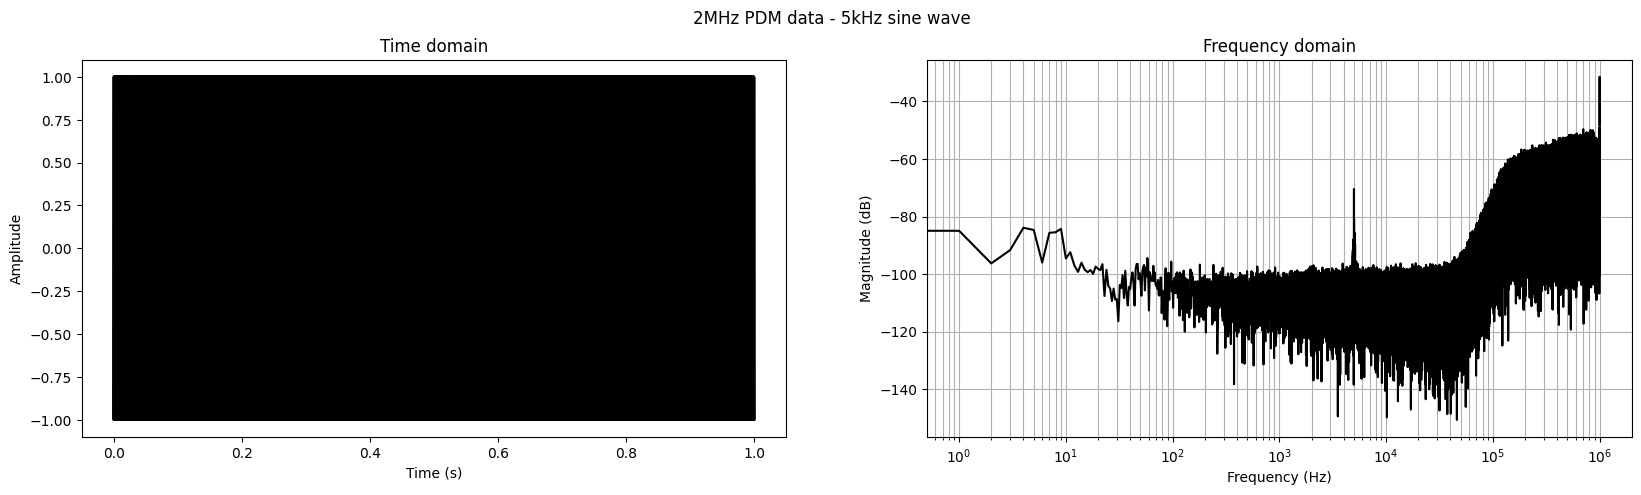

In [54]:
full_plot(2*pdm_stream[int(10e6):int(12e6)]-1, fs_pdm, short=False, title='2MHz PDM data - 5kHz sine wave')

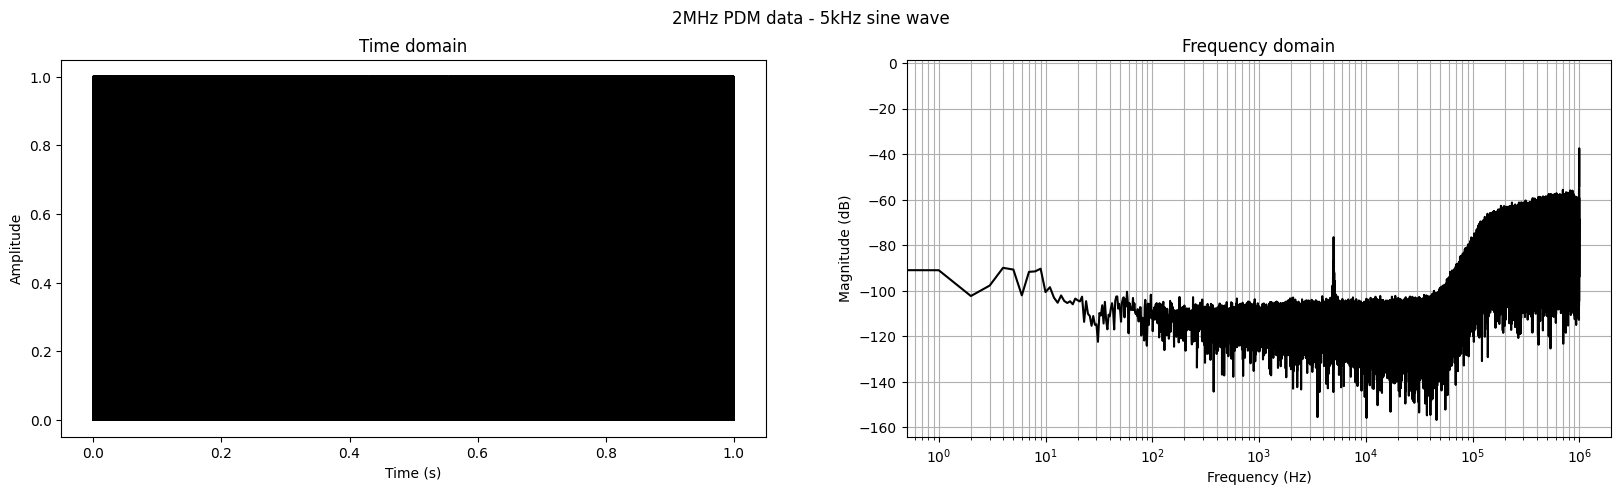

In [53]:
full_plot(pdm_stream[int(10e6):int(12e6)], fs_pdm, short=False, title='2MHz PDM data - 5kHz sine wave')

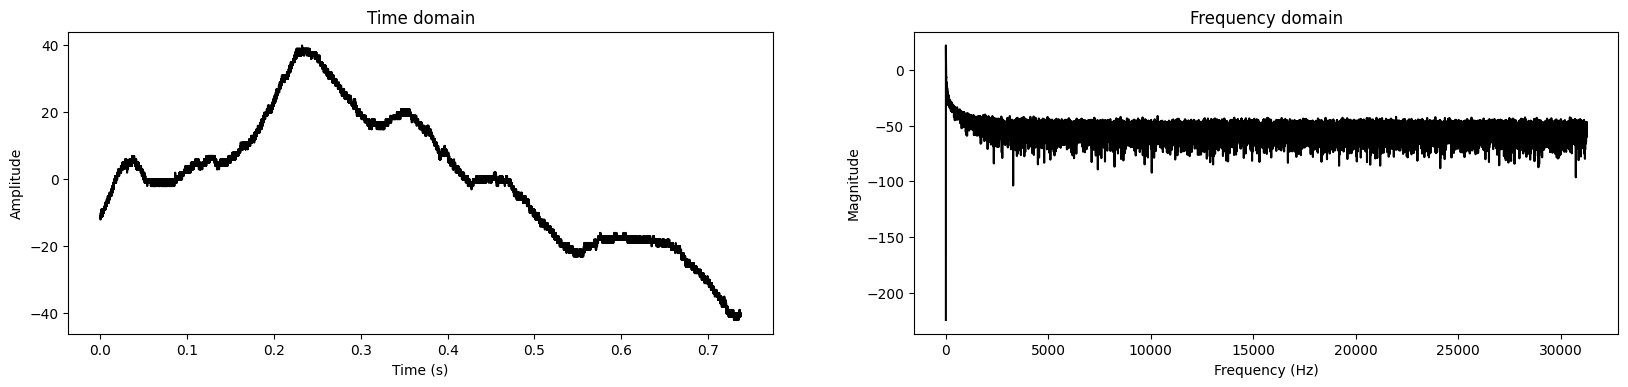

In [20]:
pdm2pcm = PDM2PCM(pdm_stream.astype(np.int32)[int(10e6):int(12e6)], fs_pdm=fs_pdm, os=32, stages=1, delay=2**14)
pdm2pcm.mag_plot()

In [14]:
sd.play(pdm2pcm.data_pcm, samplerate=fs_pdm/64)